### **Loading the required Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10, cifar100
from keras.models import Sequential
from keras.applications import VGG19
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.layers import Dropout,Conv2D, MaxPooling2D,Activation
from keras.applications import resnet50,mobilenet
# from tensorflow.keras import Sequential
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Normalizing and reshaping the model for baseline model

In [ ]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10
x_train = x_train / 255
x_test = x_test / 255
x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


## Defining functions for Precision, Recall and F1Score

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Defining the baseline model

In [ ]:
def create_basemodel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    return model

## Training the Baseline model ad saving the weights

In [ ]:
base_model = create_basemodel() 
history=base_model.fit(x_train, y_train,batch_size=258,epochs=10)

In [ ]:
base_model.save('base_model_nrml.h5')

In [ ]:
def create_plot():
      result_tab=pd.DataFrame({"Accuracy":history.history['accuracy'],"F1Score":history.history['f1_m'], "Precision":history.history['precision_m'],"Recall":history.history['recall_m']})
      fig = plt.figure(figsize=(5,5))
      plt.plot(np.arange(1,11), history.history['accuracy'], "*-",label="Accuracy")
      plt.xlabel("Num of epochs")
      plt.legend()
      plt.show()
      return result_tab

## Accuracy Plot and Other metrics tabulation

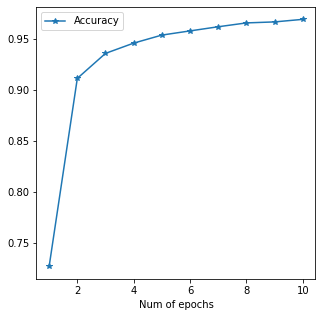

   Accuracy   F1Score  Precision    Recall
0  0.727283  0.668227   0.777280  0.614366
1  0.911600  0.910905   0.931918  0.890945
2  0.936083  0.937023   0.949763  0.924669
3  0.946150  0.946564   0.956706  0.936679
4  0.954017  0.955073   0.963027  0.947280
5  0.958117  0.958680   0.965360  0.952121
6  0.962183  0.962582   0.968365  0.956891
7  0.965950  0.965953   0.971568  0.960427
8  0.966933  0.967459   0.972421  0.962567
9  0.969433  0.969814   0.974140  0.965545


In [ ]:
tab=create_plot()
print(tab)

In [ ]:
base_model.load_weights(r'/content/drive/My Drive/SavedModels/base_model_nrml.h5')

Test_Result=base_model.evaluate(x=x_test, y=y_test, verbose=0)
print("Analysis on normal Images")
print("Base Loss: ", Test_Result[0])
print("Accuracy :" , Test_Result[1])
print("F1_Score :", Test_Result[2])

Analysis on normal Images
Base Loss:  0.06749091297388077
Accuracy : 0.9787999987602234
F1_Score : 0.9796484112739563


## Normalizing and reshaping the data for Pre-Trained Models

In [ ]:
nbr_of_clases = 10
IMG_SIZE = 32

In [ ]:
import cv2
def resize(img_array):
    tmp = np.empty((img_array.shape[0], IMG_SIZE, IMG_SIZE))
    for i in range(len(img_array)):
        # print('a',img_array[i].shape)
        img = img_array[i].reshape(28, 28).astype('uint8')
        # print('b',img.shape)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # print('c',img.shape)
        img = img.astype('float32')/255
        tmp[i] = img   
    return tmp

In [ ]:
def create_data():
      (x_train_1, y_train_1), (x_test_1, y_test_1) = mnist.load_data()
      train_x_resize = resize(x_train_1)
      test_x_resize = resize(x_test_1)
      train_x_final = np.stack((train_x_resize,)*3, axis=-1)
      test_x_final = np.stack((test_x_resize,)*3, axis=-1)
      # print(train_x_final.shape)
      # print(test_x_final.shape)
      from keras.utils import to_categorical
      train_y_final = to_categorical(y_train_1, num_classes=10)
      # print(train_y_final.shape)
      test_y_final = to_categorical(y_test_1, num_classes=10)
      # print(test_y_final.shape)
      return train_x_final,test_x_final,train_y_final,test_y_final

In [ ]:
x_train_1,x_test_1,y_train_1,y_test_1=create_data()

## Pretrained Model - VGG19

In [ ]:
def vgg_19():
    vgg19 = VGG19(weights = 'imagenet', 
                  include_top = False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model_vgg19 = Sequential()
    model_vgg19.add(vgg19)
    model_vgg19.add(Dropout(0.4))
    model_vgg19.add(Flatten())
    model_vgg19.add(Dense(10, activation='softmax'))
    model_vgg19.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', 
                  metrics=['accuracy',f1_m,precision_m,recall_m])
    model_vgg19.summary()
    return model_vgg19

In [ ]:
model_vgg19=vgg_19()
# history = model_vgg19.fit(x_train_1, y_train_1, epochs=10,batch_size=258,verbose=1)

80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 20,029,514
Trainable params: 20,029,514
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_vgg19.save('vgg19_model_nrml.h5')

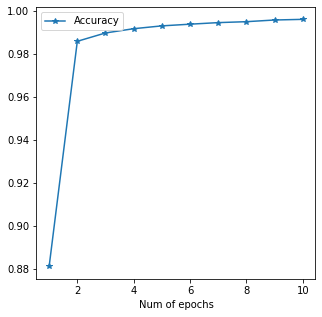

   Accuracy   F1Score  Precision    Recall
0  0.881100  0.860663   0.932332  0.837354
1  0.985933  0.985992   0.987881  0.984118
2  0.989817  0.989953   0.991186  0.988729
3  0.991800  0.991832   0.992792  0.990878
4  0.993117  0.993239   0.994085  0.992398
5  0.993900  0.993851   0.994556  0.993150
6  0.994633  0.994589   0.995029  0.994152
7  0.995067  0.995055   0.995602  0.994511
8  0.995850  0.995842   0.996207  0.995479
9  0.996150  0.996222   0.996588  0.995858


In [ ]:
tab=create_plot()
print(tab)

In [ ]:
model_vgg19.load_weights(r'/content/drive/My Drive/SavedModels/vgg19_model_nrml.h5')
Test_Result=model_vgg19.evaluate(x=x_test_1, y=y_test_1, verbose=0)
print("Analysis on normal Images")
print("Loss: ", Test_Result[0])
print("Accuracy :" , Test_Result[1])
print("F1_Score :", Test_Result[2])

Analysis on normal Images
Loss:  0.016575757414102554
Accuracy : 0.994700014591217
F1_Score : 0.9948003888130188


## Pre-Trained Model - VGG16

In [ ]:
def vgg_16():
    vgg16 = VGG16(weights = 'imagenet', 
                  include_top = False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model_vgg16 = Sequential()
    model_vgg16.add(vgg16)
    model_vgg16.add(Dropout(0.4))
    model_vgg16.add(Flatten())
    model_vgg16.add(Dense(10, activation='softmax'))
    model_vgg16.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', 
                  metrics=['accuracy',f1_m,precision_m,recall_m])
    model_vgg16.summary()
    return model_vgg16

In [ ]:
model_vgg16=vgg_16()
# # history = model_vgg16.fit(x_train_1,y_train_1 , 
#                     epochs=10, 
#                     batch_size=258)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_vgg16.save('vgg16_model_nrml.h5')

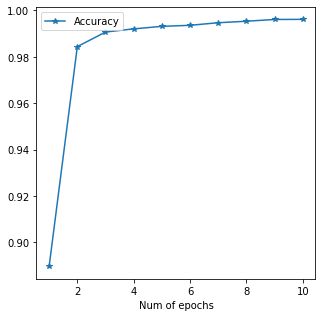

   Accuracy   F1Score  Precision    Recall
0  0.889633  0.869721   0.932973  0.847524
1  0.984367  0.984399   0.986623  0.982221
2  0.990650  0.990554   0.991761  0.989354
3  0.992017  0.992174   0.993150  0.991204
4  0.993100  0.993240   0.994003  0.992481
5  0.993550  0.993682   0.994322  0.993047
6  0.994667  0.994612   0.995108  0.994118
7  0.995300  0.995213   0.995753  0.994677
8  0.996067  0.996051   0.996375  0.995728
9  0.996117  0.996164   0.996488  0.995842
Analysis on normal Images
Loss:  0.015299591235816479
Accuracy : 0.9954000115394592
F1_Score : 0.9953535199165344


In [ ]:
tab=create_plot()
print(tab)
model_vgg16.load_weights('vgg16_model_nrml.h5')
Test_Result=model_vgg16.evaluate(x=x_test_1, y=y_test_1, verbose=0)
print("Analysis on normal Images")
print("Loss: ", Test_Result[0])
print("Accuracy :" , Test_Result[1])
print("F1_Score :", Test_Result[2])

In [ ]:
model_vgg16.load_weights(r'/content/drive/My Drive/SavedModels/vgg16_model_nrml.h5')
Test_Result=model_vgg16.evaluate(x=x_test_1, y=y_test_1, verbose=0)
print("Analysis on normal Images")
print("Loss: ", Test_Result[0])
print("Accuracy :" , Test_Result[1])
print("F1_Score :", Test_Result[2])

Analysis on normal Images
Loss:  0.015299591235816479
Accuracy : 0.9954000115394592
F1_Score : 0.9953535199165344


## Pre-Trained Model - Resnet50

In [ ]:
def resnet():
      resnet_model = resnet50.ResNet50(weights='imagenet')
      model_resnet = Sequential()
      model_resnet.add(resnet_model)
      model_resnet.add(Dropout(0.4))
      model_resnet.add(Flatten())
      model_resnet.add(Dense(10, activation='softmax'))
      model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
      model_resnet.summary()
      return model_resnet

In [ ]:
model_resnet=resnet()
# history = model_resnet.fit(x_train_1, y_train_1, 
#                     epochs=10, 
#                     batch_size=258)

102973440/102967424 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10010     
Total params: 25,646,722
Trainable params: 25,593,602
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model_resnet.save('resnet_model_nrml.h5')

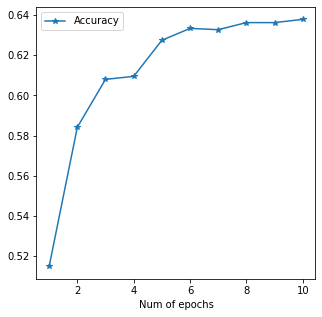

   Accuracy   F1Score  Precision    Recall
0  0.514817  0.000000   0.000000  0.000000
1  0.584117  0.000000   0.000000  0.000000
2  0.607950  0.048761   0.147482  0.031571
3  0.609450  0.666016   0.947607  0.516682
4  0.627417  0.725074   0.968543  0.579962
5  0.633317  0.734031   0.979851  0.587390
6  0.632700  0.733069   0.982247  0.585273
7  0.636217  0.736633   0.984659  0.588959
8  0.636217  0.737212   0.986932  0.588923
9  0.637833  0.739260   0.990484  0.590253
Analysis on normal Images
Loss:  0.5024979710578918
Accuracy : 0.9836999773979187
F1_Score : 0.981224775314331


In [ ]:
tab=create_plot()
print(tab)
model_resnet.load_weights('resnet_model_nrml.h5')
Test_Result=model_resnet.evaluate(x=x_test_1, y=y_test_1, verbose=0)
print("Analysis on normal Images")
print("Loss: ", Test_Result[0])
print("Accuracy :" , Test_Result[1])
print("F1_Score :", Test_Result[2])

### **Pre-Trained Model -- Mobilenet**

In [ ]:
def mobilenet():
      mobilenet_model = tf.keras.applications.MobileNet(weights = 'imagenet')
      model_mobilenet = Sequential()
      model_mobilenet.add(mobilenet_model)
      model_mobilenet.add(Dropout(0.4))
      model_mobilenet.add(Flatten())
      model_mobilenet.add(Dense(10, activation='softmax'))
      model_mobilenet.compile(loss='categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy',f1_m,precision_m, recall_m])

      model_mobilenet.summary()
      return model_mobilenet

In [ ]:
model_mobilenet=mobilenet()
# history = model_mobilenet.fit(x_train_1, y_train_1, 
#                     epochs=10, 
#                     batch_size=258)

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1000)              4253864   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10010     
Total params: 4,263,874
Trainable params: 4,241,986
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
model_mobilenet.save('mobilenet_model_nrml.h5')

In [ ]:
model_mobilenet.load_weights(r'/content/drive/My Drive/SavedModels/mobilenet_model_nrml.h5')
Test_Result=model_mobilenet.evaluate(x=x_test_1, y=y_test_1, verbose=0)
print("Analysis on normal Images")
print("Loss: ", Test_Result[0])
print("Accuracy :" , Test_Result[1])
print("F1_Score :", Test_Result[2])

Analysis on normal Images
Loss:  0.696761965751648
Accuracy : 0.9325000047683716
F1_Score : 0.9238060116767883


## Defining functions to generated perturbated images

In [ ]:
def adversarial_pattern(image, label,model):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [ ]:
def generate_adversarials(batch_size,attack,x_train,y_train,model):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)
            label = y_train[N]
            image = x_train[N]
            perturbations = adversarial_pattern(image.reshape(-1,img_rows, img_cols, channels),label,model).numpy()
            epsilon = 0.1
            decay_factor=1.0
            iter = 10
            alpha = epsilon/iter
            g=0
            pert_out = image
            if attack == "fgsm":
              pert_out = pert_out + perturbations * epsilon
              x.append(pert_out)
              y.append(y_train[N])
            elif attack == "s&p":
              row,col,ch = image.shape
              s_vs_p = 0.5
              amount = 0.4
              out = np.copy(image)
              # Salt mode
              num_salt = np.ceil(amount * image.size * s_vs_p)
              # print(num_salt)
              coords = [np.random.randint(0, j - 1, int(num_salt))
                      for j in image.shape]
              # print(coords)
              out[coords[0], coords[1], coords[2]] = 1

              # Pepper mode
              num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
              # print (num_pepper)
              coords = [np.random.randint(0, j - 1, int(num_pepper))
                      for j in image.shape]
              out[coords[0], coords[1], coords[2]] = 0
              # plt.imshow(out)
              # plt.show()
              x.append(out)
              y.append(train_y_final[N])
            elif attack == "rnoise":
              noise_factor = 1
              noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape) 
              out = np.clip(noisy, 0., 1.)
              x.append(out)
              y.append(train_y_final[N])
            elif attack == "pgd":
              for i in range(iter-1):
                pert_out = pert_out + alpha*perturbations
                pert_out = torch.from_numpy(pert_out)
                pert_out = torch.clamp(pert_out, 0, 1)
                if torch.norm((pert_out-image),p=float('inf')) > epsilon:
                  break
                pert_out = pert_out.numpy()
              x.append(pert_out)
              y.append(y_train[N])
            elif attack == "mifgsm":
              for i in range(iter-1):
                p = torch.from_numpy(perturbations)
                g = decay_factor*g + p/torch.norm(p)
                pert_out = torch.from_numpy(pert_out)
                pert_out = pert_out + alpha*torch.sign(g)
                pert_out = torch.clamp(pert_out, 0, 1)
                if torch.norm((pert_out-image),p=float('inf')) > epsilon:
                  break
                pert_out = pert_out.numpy()
              x.append(pert_out)
              y.append(y_train[N])
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        yield x, y

## Generating data using different attacks and evaluating the models 

In [ ]:
# Analysis before defense with adversarial inputs
img_rows, img_cols, channels = 28, 28, 1
comparision=pd.DataFrame()
x_adversarial_test,y_adversarial_test = next(generate_adversarials(10000,'pgd',x_train,y_train,base_model))
Test_Result=base_model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0)
print(Test_Result)
comparision=comparision.append({'Model':'BaseModel','Loss':Test_Result[0],'Accuracy':Test_Result[1],'F1_Score':Test_Result[2]},ignore_index=True)
img_rows, img_cols, channels = 32, 32, 3
x_adversarial_test_19,y_adversarial_test_19 = next(generate_adversarials(10000,'pgd',x_train_1,y_train_1,model_vgg19))
Test_Result=model_vgg19.evaluate(x=x_adversarial_test_19, y=y_adversarial_test_19, verbose=0)
print(Test_Result)
comparision=comparision.append({"Model":"vgg-19","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True)
x_adversarial_test_16,y_adversarial_test_16 = next(generate_adversarials(10000,'pgd',x_train_1,y_train_1,model_vgg16))
Test_Result=model_vgg16.evaluate(x=x_adversarial_test_16, y=y_adversarial_test_16, verbose=0)
comparision=comparision.append({"Model":"vgg-16","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True)
x_adversarial_test_res,y_adversarial_test_res = next(generate_adversarials(10000,'fgsm',x_train_1,y_train_1,model_resnet))
Test_Result=model_resnet.evaluate(x=x_adversarial_test_res, y=y_adversarial_test_res, verbose=0)
comparision=comparision.append({"Model":"Resnet","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True)
x_adversarial_test_mob,y_adversarial_test_mob = next(generate_adversarials(10000,'fgsm',x_train_1,y_train_1,model_mobilenet))
Test_Result=model_mobilenet.evaluate(x=x_adversarial_test_mob, y=y_adversarial_test_mob, verbose=0)
comparision=comparision.append({"Model":"MobileNet","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True) 

## Generating data with perturbated images using the different attacks for training the models and evaluating the models after training

In [ ]:
#Analysis after defending the adversarial attack on adversarial input
img_rows, img_cols, channels = 28, 28, 1
com_def=pd.DataFrame()
x_adversarial_train, y_adversarial_train = next(generate_adversarials(15000,"pgd",x_train,y_train,base_model))
base_model.fit(x_adversarial_train, y_adversarial_train,batch_size=256,epochs=10)
Test_Result=base_model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0)
com_def=com_def.append({'Model':'BaseModel','Loss':Test_Result[0],'Accuracy':Test_Result[1],'F1_Score':Test_Result[2]},ignore_index=True)
img_rows, img_cols, channels = 32, 32, 3
x_adversarial_train,y_adversarial_train = next(generate_adversarials(15000,'pgd',x_train_1,y_train_1,model_vgg19))
model_vgg19.fit(x_adversarial_train, y_adversarial_train,batch_size=256,epochs=10)
Test_Result=model_vgg19.evaluate(x=x_adversarial_test_19, y=y_adversarial_test_19, verbose=0)
com_def=com_def.append({"Model":"Vgg-19","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True)
x_adversarial_train,y_adversarial_train = next(generate_adversarials(15000,'pgd',x_train_1,y_train_1,model_vgg16))
model_vgg16.fit(x_adversarial_train, y_adversarial_train,batch_size=256,epochs=10)
Test_Result=model_vgg16.evaluate(x=x_adversarial_test_16, y=y_adversarial_test_16, verbose=0)
com_def=com_def.append({"Model":"Vgg-16","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True)
x_adversarial_train,y_adversarial_train = next(generate_adversarials(15000,'fgsm',x_train_1,y_train_1,model_resnet))
model_resnet.fit(x_adversarial_train, y_adversarial_train,batch_size=256,epochs=10)
Test_Result=model_resnet.evaluate(x=x_adversarial_test_res, y=y_adversarial_test_res, verbose=0)
com_def=com_def.append({"Model":"Resnet","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True)
x_adversarial_train,y_adversarial_train = next(generate_adversarials(15000,'fgsm',x_train_1,y_train_1,model_mobilenet))
model_mobilenet.fit(x_adversarial_train, y_adversarial_train,batch_size=256,epochs=10)
Test_Result=model_mobilenet.evaluate(x=x_adversarial_test_mob, y=y_adversarial_test_mob, verbose=0)
com_def=com_def.append({"Model":"Mobilenet","Loss":Test_Result[0],"Accuracy":Test_Result[1],"F1_Score":Test_Result[2]},ignore_index=True)